### WLensingtool example

In [2]:
import WLensingtool
from WLensingtool import *

import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

from astropy.io import fits
from astropy.visualization import ZScaleInterval
ZSI = ZScaleInterval()

np.set_printoptions(suppress=True)
plt.rc('text', usetex=False)

##### We use here the UNCOVER catalog of A2744 galaxy cluster, which can be found here: https://jwst-uncover.github.io/DR2.html

In [4]:
## First, we load the catalog already in ndarray form:
GC_array = np.load("GC_array.npy")


## Then we assign a different array for each column of interest,
## and filter them according to (the cluster is at z=0.308):
use_phot = GC_array[:, 66]
flag_lowsnr = GC_array[:, 68]
flag_nearbcg = GC_array[:, 71]
redshift = GC_array[:, 82]
ind = np.where((redshift > 0.7) & (redshift < 5) & (use_phot == 1) & (flag_lowsnr == 0) & (flag_nearbcg == 0))[0]

x = GC_array[ind, 1]  # pixels
y = GC_array[ind, 2]  # pixels
a = GC_array[ind, 62]  # pixels
b = GC_array[ind, 63]  # pixels
phi_PSF = GC_array[ind, 64]  # rad
cluster_image = fits.open('abell2744clu-grizli-v7.0-f444w-clear_drc_sci.fits.gz')[0].data
seg_map = fits.open('UNCOVER_DR2_LW_SEGMAP.fits.gz')[0].data
PSF_normed = fits.open('f444w_psf.fits')[0].data
wcs = WCS(fits.open('abell2744clu-grizli-v7.0-f444w-clear_drc_sci.fits.gz')[0].header)

In [5]:
## Setting the instance of our light souces catalog class:
ls = light_sources(x, y, a, b, phi_PSF, cluster_image, seg_map, PSF_normed)

## Filtering the galaxies by size (i.e., keeping the ones with distinguishable shapes):
ind_size = ls.size_filter()
print(ind_size.shape)

x = x[ind_size]
y = y[ind_size] 
a = a[ind_size]  
b = b[ind_size]  
phi_PSF = phi_PSF[ind_size]

## Resetting the instance of our light souces catalog class:
ls = light_sources(x, y, a, b, phi_PSF, cluster_image, seg_map, PSF_normed)

(20348,)


##### Next, we need to deconvolve the the galaxies' images from the aperature's PSF. Since there are a lot of galaxies it is recommended to parallelize the computation by adding the following lines to a .py document and running it at the terminal:

In [ ]:
import sys
from joblib import Parallel, delayed

num_cores = int(sys.argv[1])  # this accepts the number of cores from the excecution line in the terminal:
                              # python {your_WL_code}.py {num_of_cores}

results = Parallel(n_jobs = num_cores, prefer="threads")(delayed(ls.deconvolver)(i, nsteps=10000, MCMC_progress=False) for i in range(len(ind_size)))
np.save("e1e2", np.asarray(results))    

##### The result is a 4 $\times$ len(galaxies) array, from which we need:

In [ ]:
e1e2 = np.load("e1e2.npy")
e1 = e1e2[:, 1]
e2 = e1e2[:, 2]

##### Now we are able to compute the shear map (notice how the WL signal is prominent!):

In [7]:
divx = 37
divy = 32

g1, g1_std, g2, g2_std, g, phi_mean, jacobian_xy, x_axis_cells, y_axis_cells = ls.shear(e1, e2, x, y, divx=divx, divy=divy)

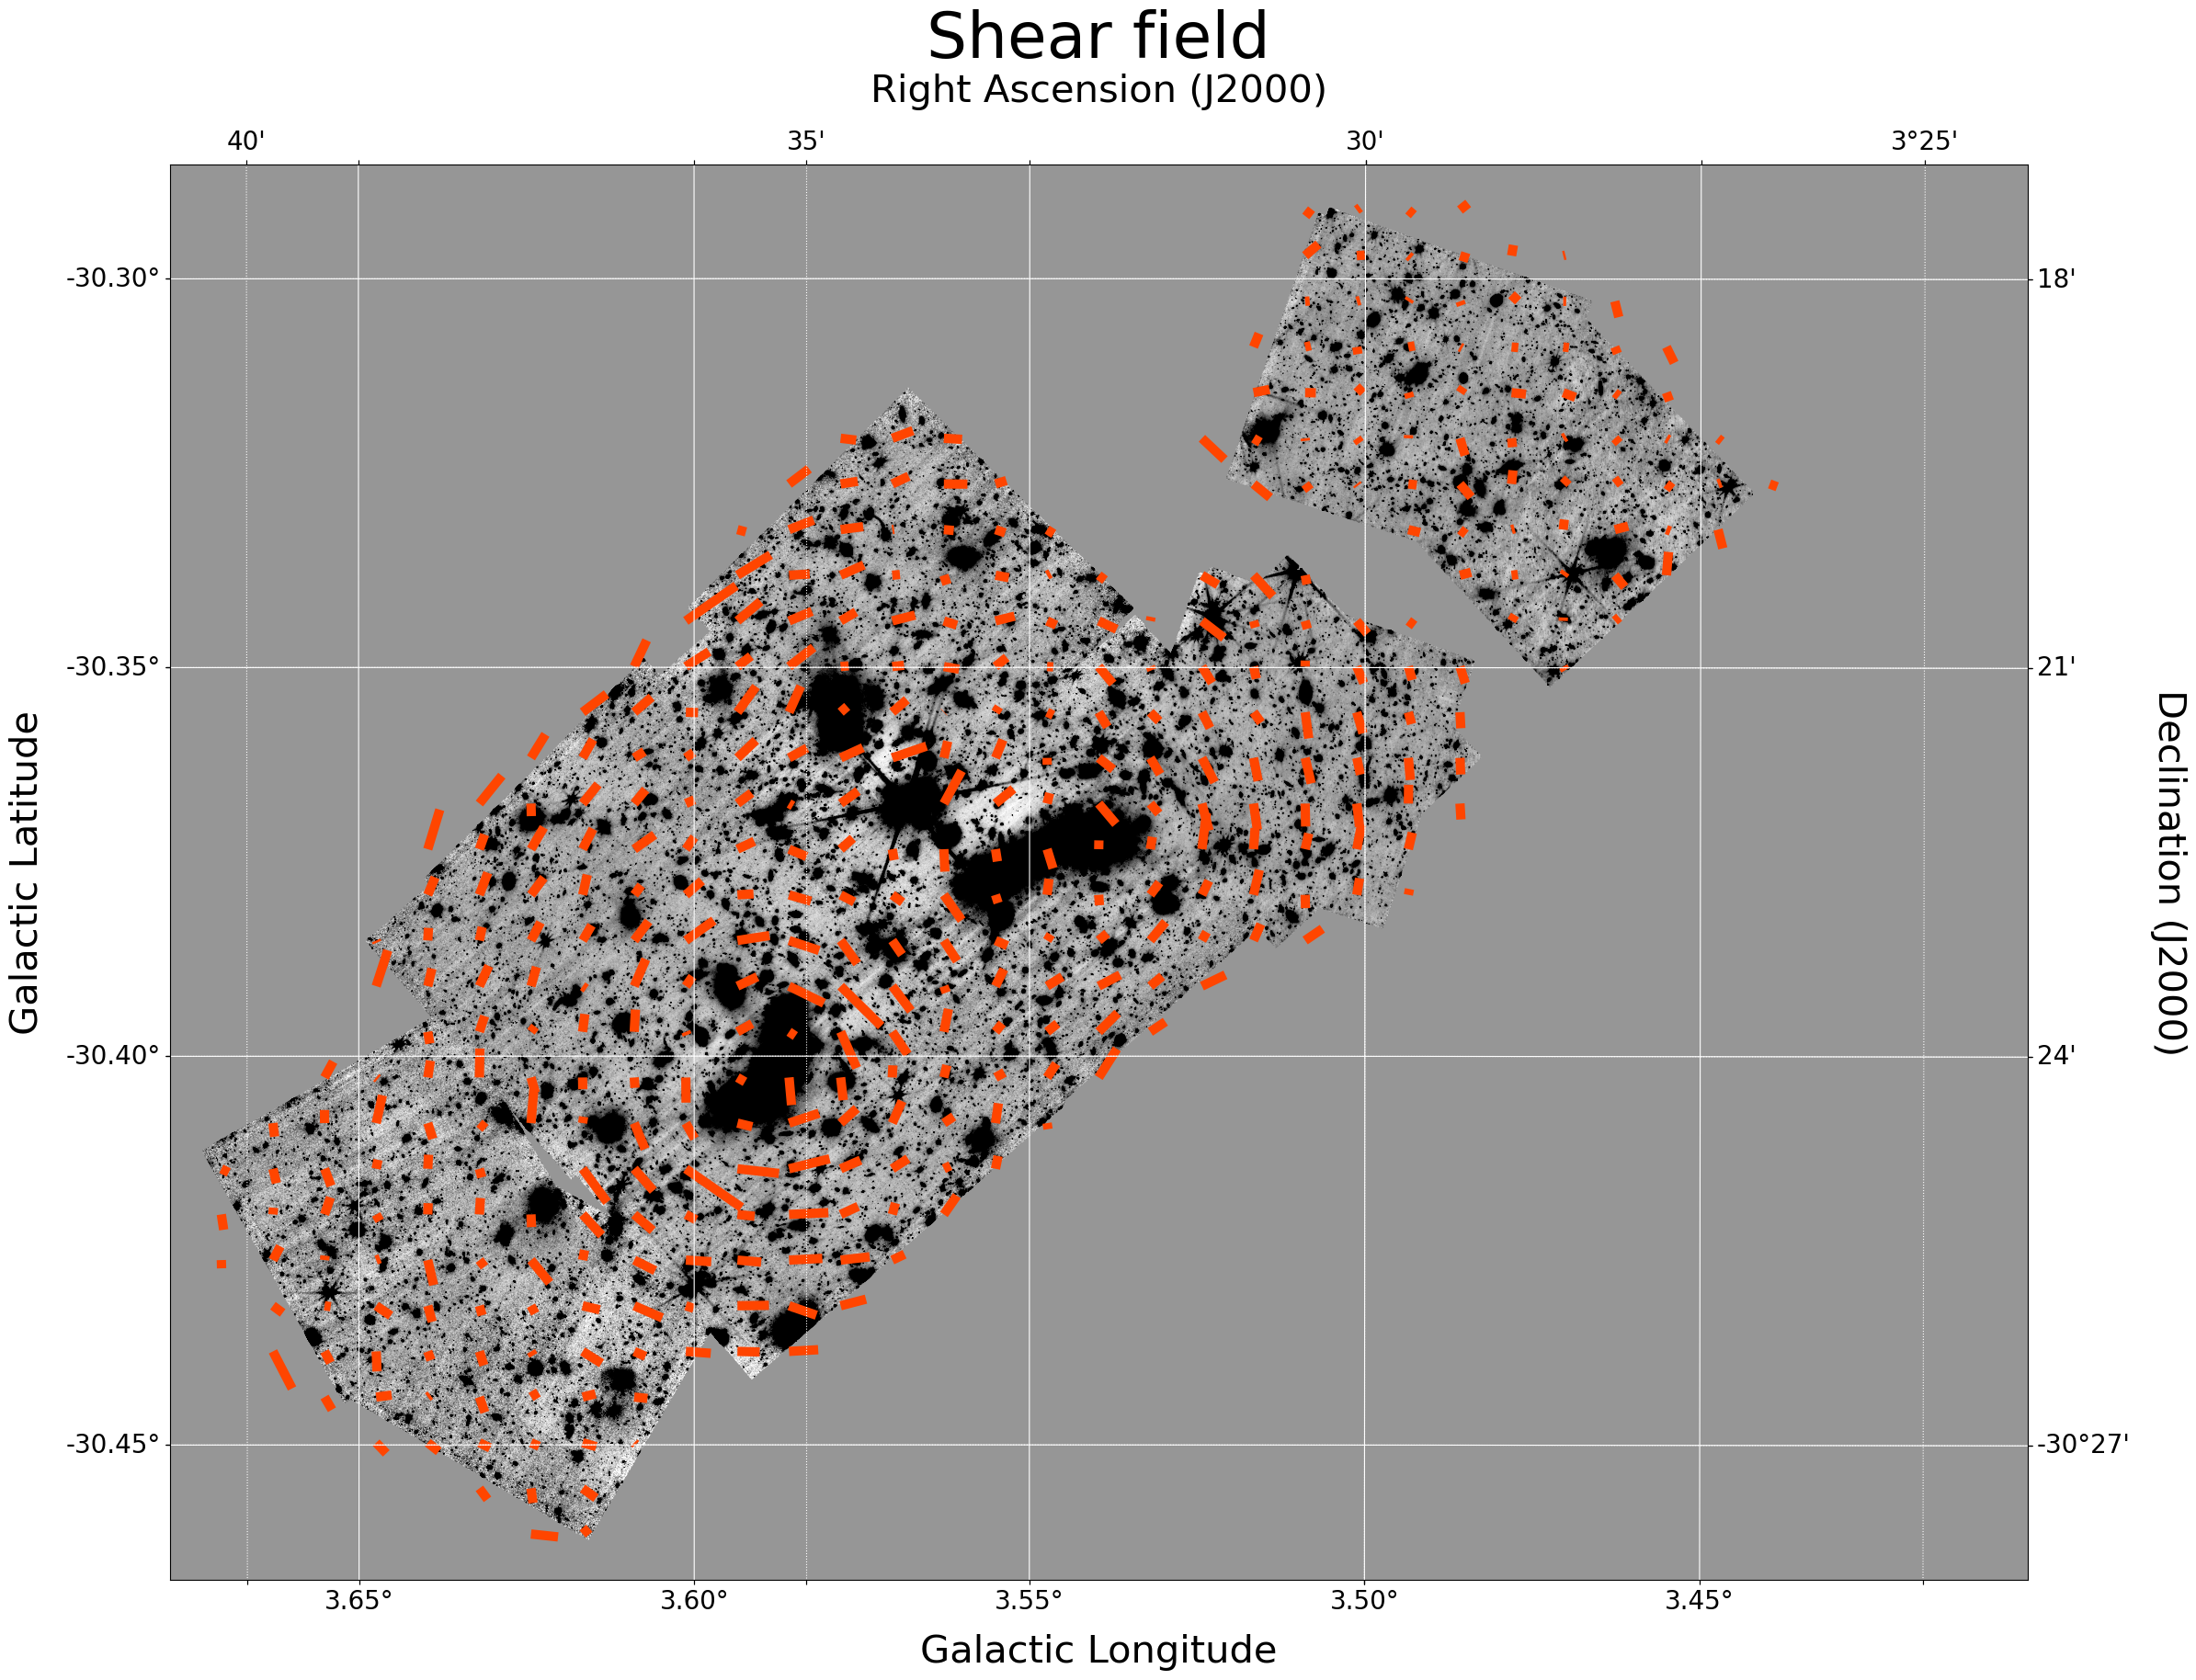

In [8]:
fig = plt.figure(figsize=(40, 20))
ax = plt.subplot(projection=wcs, label='overlays')
ax.set_title("Shear field", size=50, y=1.07)


## cluster image:
zm1_GC, zm2_GC = ZSI.get_limits(cluster_image[0:cluster_image.shape[0], 0:cluster_image.shape[1]])
plt.imshow(cluster_image, vmin=zm1_GC, vmax=zm2_GC, origin='lower', cmap='Greys')


## overlaying the shear:
plt.quiver(x_axis_cells, y_axis_cells, g * np.cos(phi_mean), g * np.sin(phi_mean), scale=10, color=['orangered'], width=0.005,
           headwidth=0, headlength=0, headaxislength=0, minshaft=0, minlength=0)


## grid overlay:
ax.coords.grid(True, color='white', ls='solid')
ra = ax.coords[0]
ra.set_major_formatter('d.dd')
ra.set_axislabel('Galactic Longitude', size=30)
ra.tick_params(labelsize=20)
dec = ax.coords[1]
dec.set_major_formatter('d.dd')
dec.set_axislabel('Galactic Latitude', size=30)
dec.tick_params(labelsize=20)

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)', size=30)
overlay[0].tick_params(labelsize=20)
overlay[1].set_axislabel('Declination (J2000)', size=30)
overlay[1].tick_params(labelsize=20)


plt.xlim(0, cluster_image.shape[1])
plt.ylim(0, cluster_image.shape[0])


plt.show()

##### and the convergence map (notice how it corresponds to the light concentrations!):

In [8]:
kappa_g = ls.convergence_map(x_axis_cells, y_axis_cells, g1, g2, jacobian_xy, divx, divy)


## excluding cells outsite the FOV:
x_min = 0
y_min = 0
x_max = cluster_image.shape[1]
y_max = cluster_image.shape[0]

x_div = (x_max - x_min) / divx
y_div =  (y_max - y_min) / divy

indices = [(nx, ny) for nx in range(divx) for ny in range(divy) if cluster_image[int(y_min + ny * y_div), int(x_min + nx * x_div)] == 0.0]
x_indices, y_indices = zip(*indices)
kappa_g[y_indices, x_indices] = np.nan

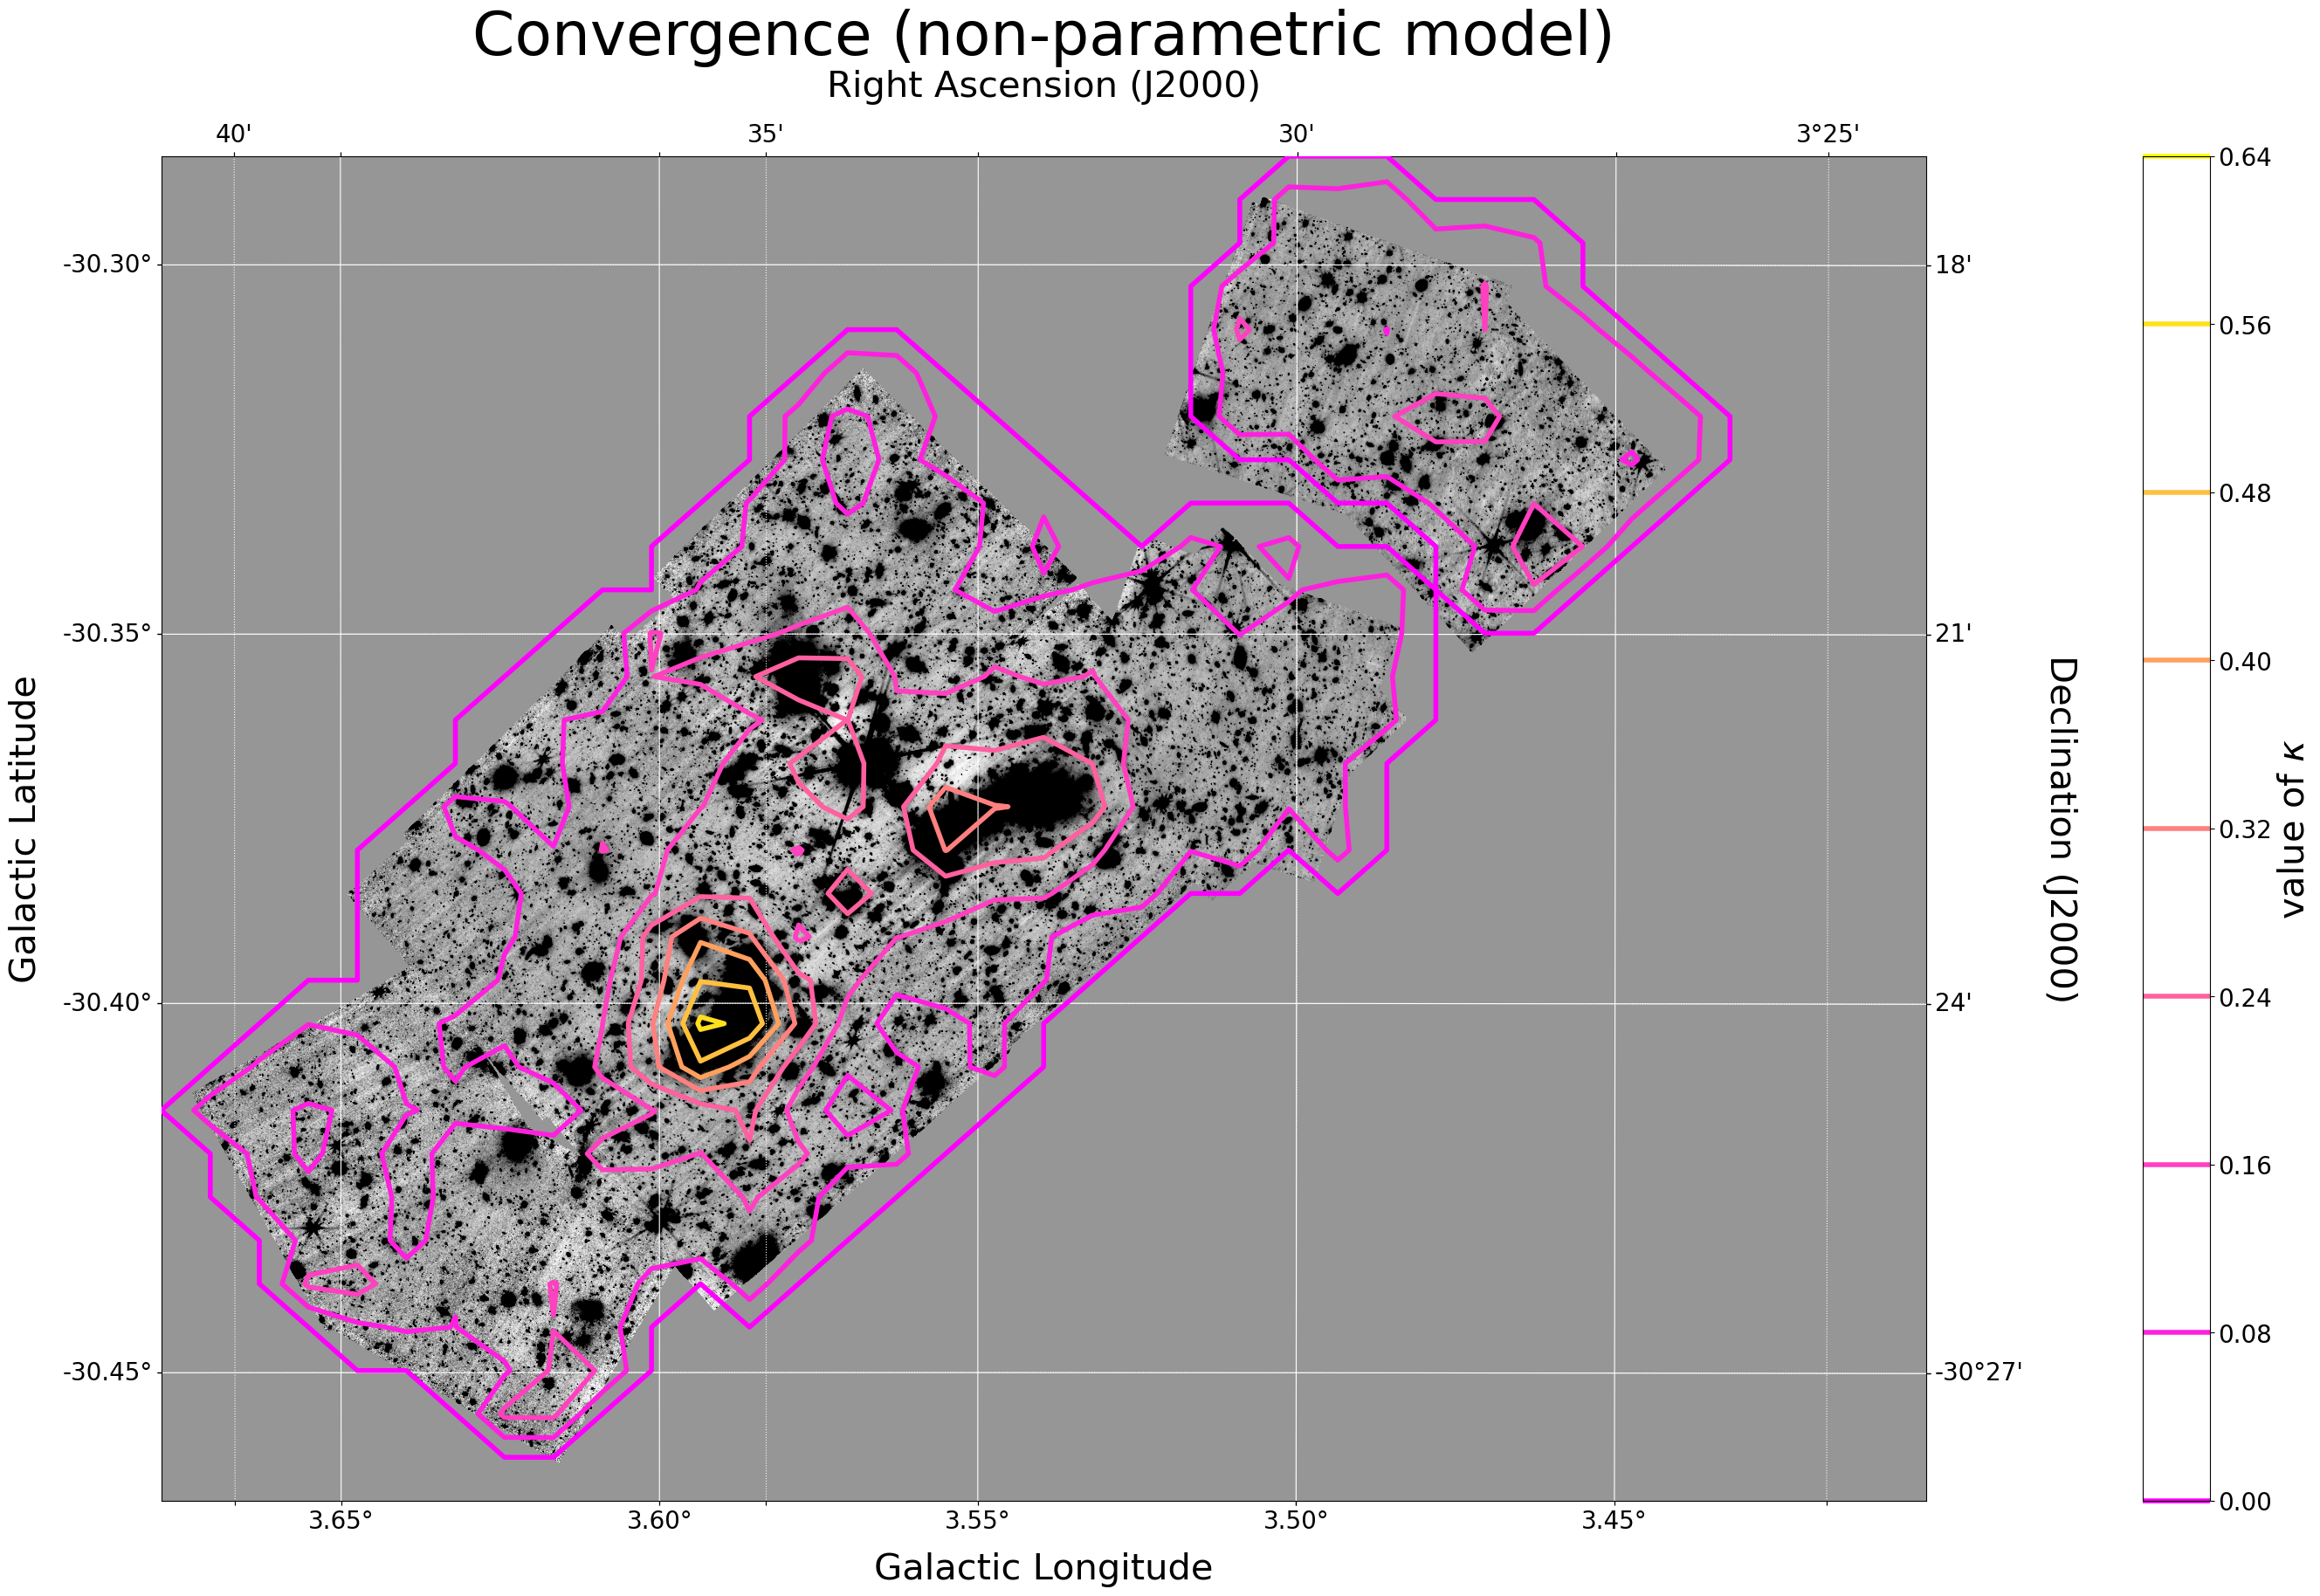

In [10]:
fig = plt.figure(figsize=(40, 20))
ax = plt.subplot(projection=wcs, label='overlays')
ax.set_title("Convergence (non-parametric model)", size=50, y=1.07)


## cluster image:
zm1_GC, zm2_GC = ZSI.get_limits(cluster_image[0:cluster_image.shape[0], 0:cluster_image.shape[1]])
plt.imshow(cluster_image, vmin=zm1_GC, vmax=zm2_GC, origin='lower', cmap='Greys')


## overlaying the convergence (mass sheet degeneracy allows to avoid negative values):
kappa_map = kappa_g + np.abs(np.min(kappa_g[np.where(~ np.isnan(kappa_g))]))
kappa_map[np.isnan(kappa_map)] = 0
im = plt.contour(x_axis_cells, y_axis_cells, kappa_map, 
                 origin='lower', cmap='spring', linewidths=4)
cbar = plt.colorbar(im, pad=0.08)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label=r'value of $\kappa$', size=30)


## grid overlay:
ax.coords.grid(True, color='white', ls='solid')
ra = ax.coords[0]
ra.set_major_formatter('d.dd')
ra.set_axislabel('Galactic Longitude', size=30)
ra.tick_params(labelsize=20)
dec = ax.coords[1]
dec.set_major_formatter('d.dd')
dec.set_axislabel('Galactic Latitude', size=30)
dec.tick_params(labelsize=20)

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)', size=30)
overlay[0].tick_params(labelsize=20)
overlay[1].set_axislabel('Declination (J2000)', size=30)
overlay[1].tick_params(labelsize=20)


plt.show()

##### We can also use the parametric PIEMD model, where for the case of A2744 a joint model of 5 PIEMDs is needed. This model's parameters can be then fitted by using an MCMC algorithm:

In [9]:
z = GC_array[ind, 82][ind_size]  # redshift of the background sources
z_A2744 = 0.308

D_l = d_A_z(z_A2744)  # observer-lens; Mpc
D_s = d_A_z(np.median(z))  # observer-source; Mpc
D_ls = d_A_z1z2(z_A2744, np.median(z))  # lens-source; Mpc


params = np.array([6690, 5530, 0.2, 0.09 * np.pi, 800, 0.1, 
                   7130, 6020, 0.2, 0.47 * np.pi, 800, 0.1,
                   9620, 8190, 0.2, 0.1 * np.pi, 800, 0.1,
                   10560, 8550, 0.2, -0.046 * np.pi, 800, 0.1,
                   7730, 9940, 0.2, 0.4 * np.pi, 800, 0.1])


def joint_PIEMD(grid_x, grid_y, params):  # we use the default values of pixel_in_DD, pixels_in_x, pixels_in_y
    
    center_x1, center_y1, eps1, phi1, sigma_v1, r_core1 = params[0:6]
    center_x2, center_y2, eps2, phi2, sigma_v2, r_core2 = params[6:12]
    center_x3, center_y3, eps3, phi3, sigma_v3, r_core3 = params[12:18]
    center_x4, center_y4, eps4, phi4, sigma_v4, r_core4 = params[18:24]
    center_x5, center_y5, eps5, phi5, sigma_v5, r_core5 = params[24:30]
    
    clump_1 = PIEMD(grid_x, grid_y, center_x1, center_y1, eps1, phi1, sigma_v1, r_core1, D_l, D_s, D_ls)
    clump_2 = PIEMD(grid_x, grid_y, center_x2, center_y2, eps2, phi2, sigma_v2, r_core2, D_l, D_s, D_ls)
    clump_3 = PIEMD(grid_x, grid_y, center_x3, center_y3, eps3, phi3, sigma_v3, r_core3, D_l, D_s, D_ls)
    clump_4 = PIEMD(grid_x, grid_y, center_x4, center_y4, eps4, phi4, sigma_v4, r_core4, D_l, D_s, D_ls)
    clump_5 = PIEMD(grid_x, grid_y, center_x5, center_y5, eps5, phi5, sigma_v5, r_core5, D_l, D_s, D_ls)
    
    kappa = clump_1.kappa() + clump_2.kappa() + clump_3.kappa() + clump_4.kappa() + clump_5.kappa()
    
    return kappa

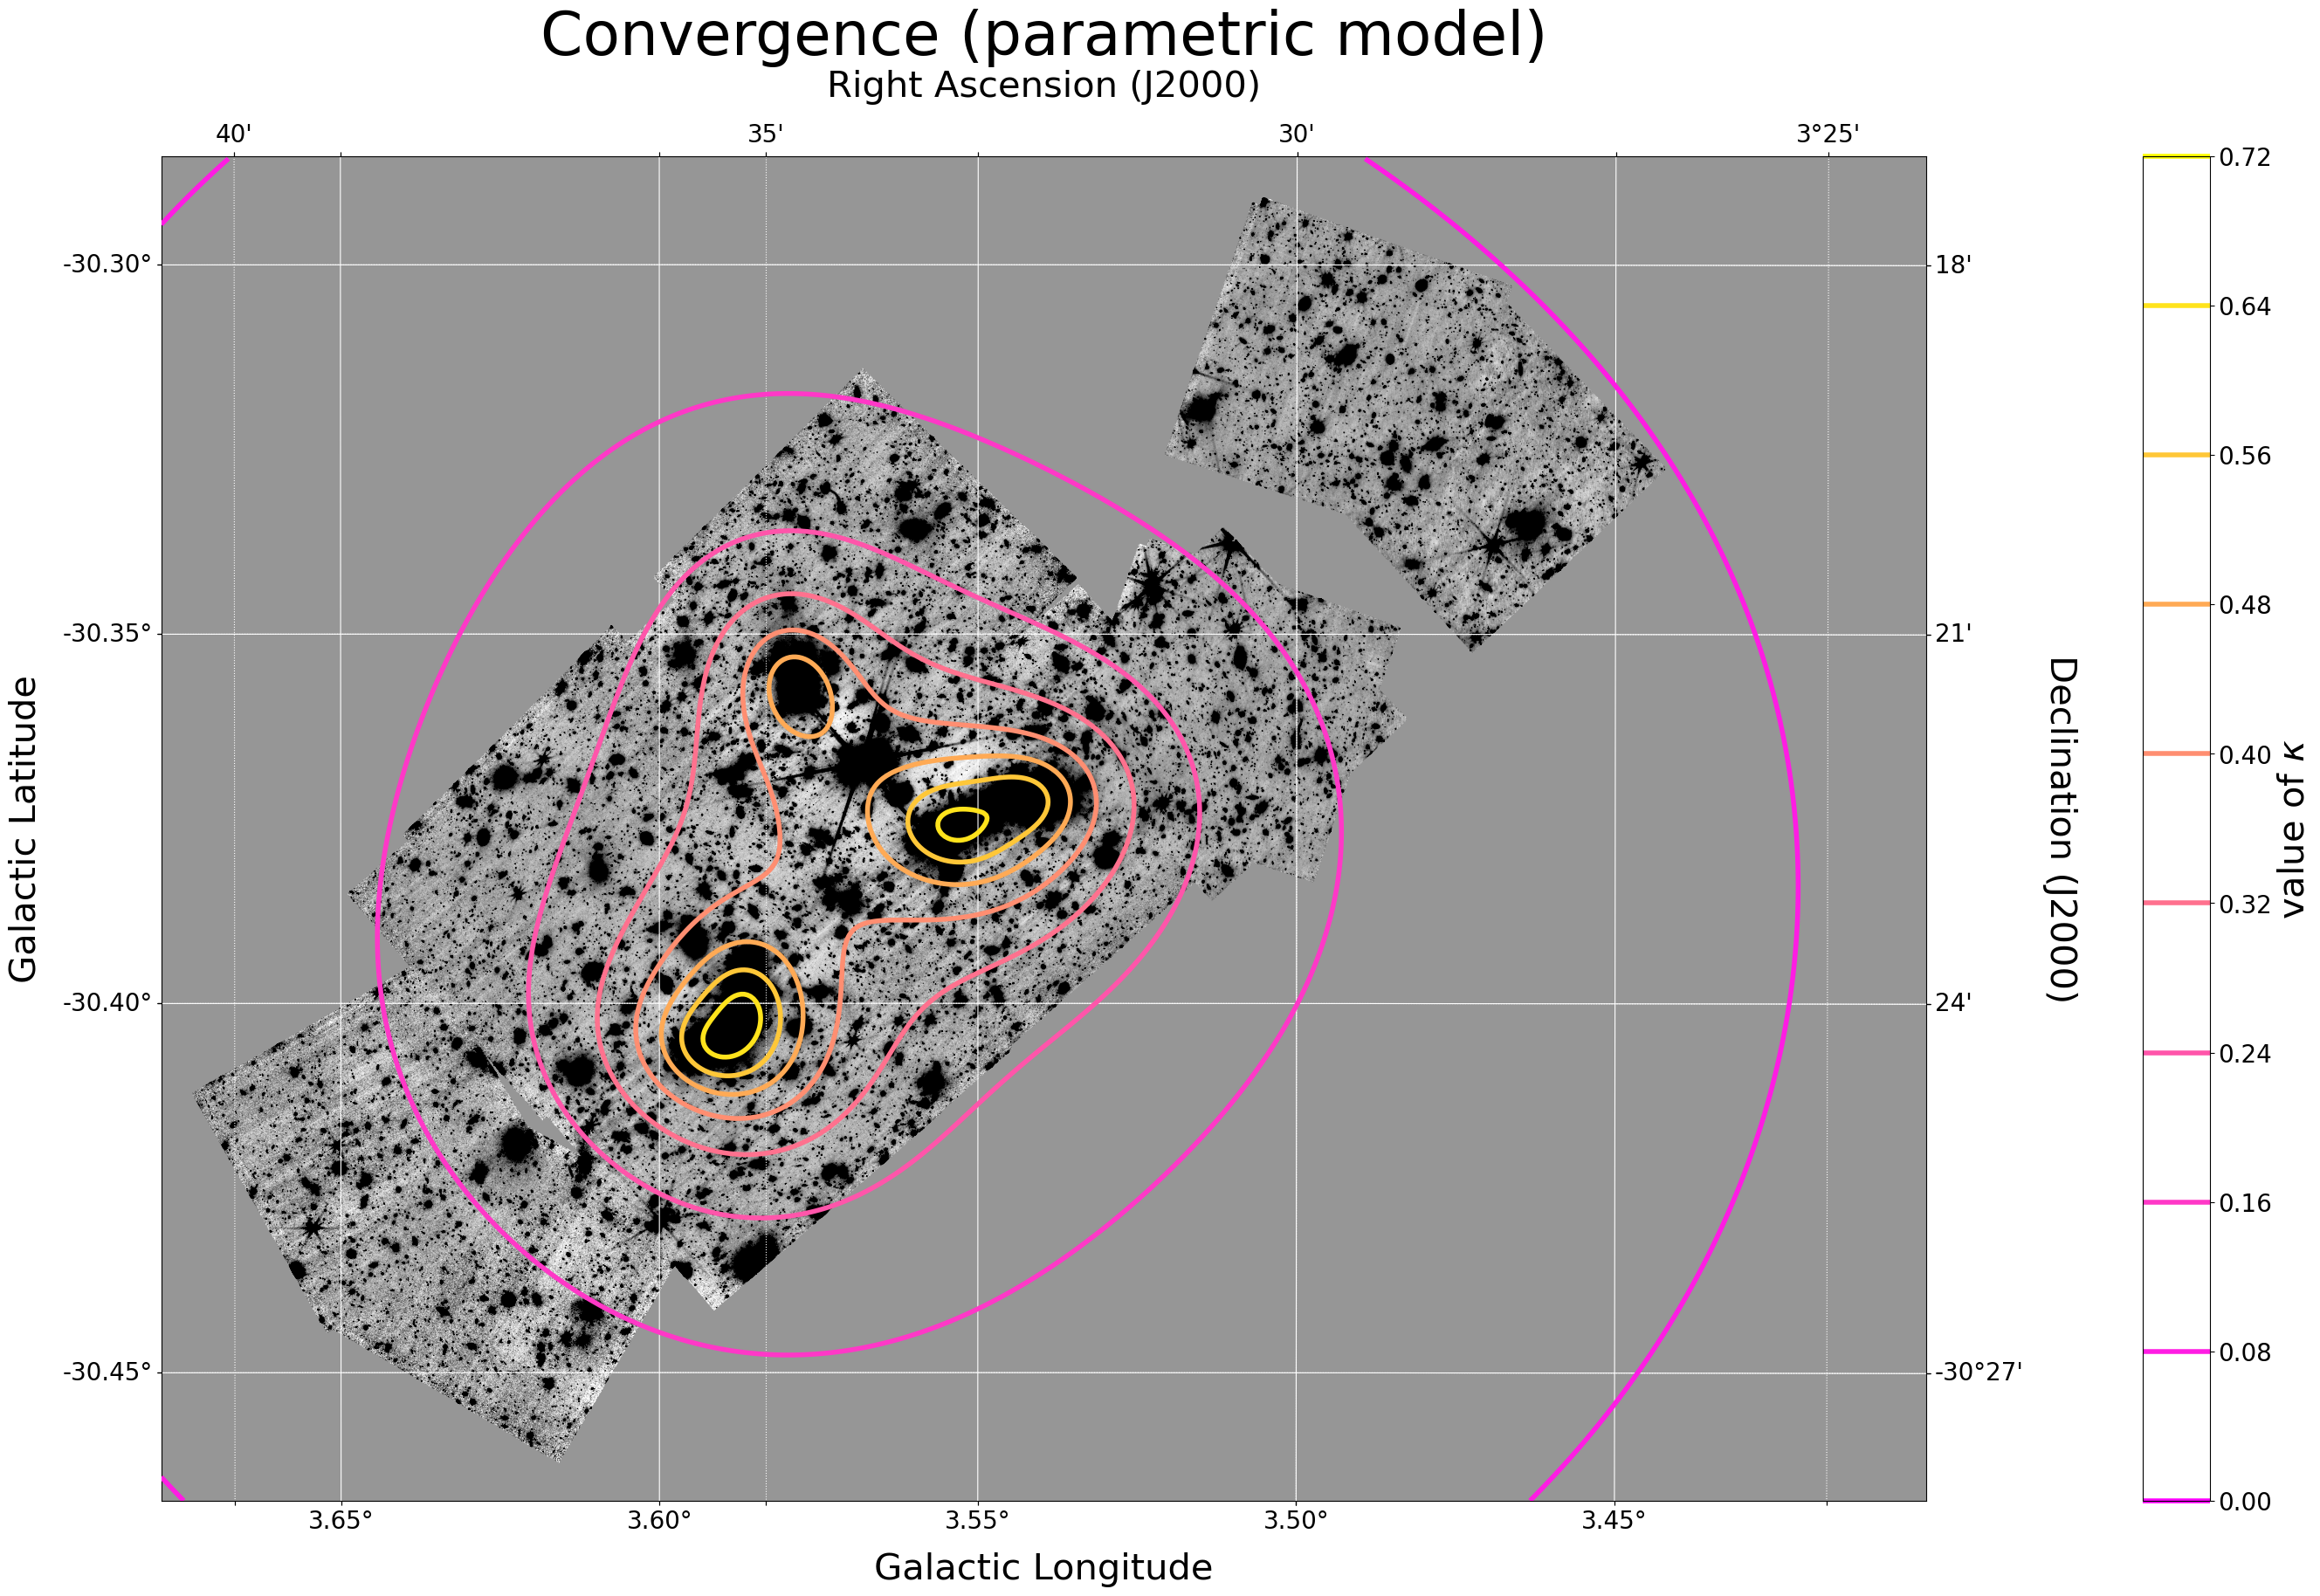

In [12]:
fig = plt.figure(figsize=(40, 20))
ax = plt.subplot(projection=wcs, label='overlays')
ax.set_title("Convergence (parametric model)", size=50, y=1.07)


## cluster image:
zm1_GC, zm2_GC = ZSI.get_limits(cluster_image[0:cluster_image.shape[0], 0:cluster_image.shape[1]])
plt.imshow(cluster_image, vmin=zm1_GC, vmax=zm2_GC, origin='lower', cmap='Greys')


## overlaying the convergence:
x_FOV = np.arange(0, cluster_image.shape[1], divx)
y_FOV = np.arange(0, cluster_image.shape[0], divy)
xx_FOV, yy_FOV = np.meshgrid(x_FOV, y_FOV)
kappa = joint_PIEMD(xx_FOV, yy_FOV, params)

im = plt.contour(xx_FOV, yy_FOV, kappa, cmap='spring', linewidths=4)
cbar = plt.colorbar(im, pad=0.08)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label=r'value of $\kappa$', size=30)


## grid overlay:
ax.coords.grid(True, color='white', ls='solid')
ra = ax.coords[0]
ra.set_major_formatter('d.dd')
ra.set_axislabel('Galactic Longitude', size=30)
ra.tick_params(labelsize=20)
dec = ax.coords[1]
dec.set_major_formatter('d.dd')
dec.set_axislabel('Galactic Latitude', size=30)
dec.tick_params(labelsize=20)

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)', size=30)
overlay[0].tick_params(labelsize=20)
overlay[1].set_axislabel('Declination (J2000)', size=30)
overlay[1].tick_params(labelsize=20)


plt.xlim(0, cluster_image.shape[1])
plt.ylim(0, cluster_image.shape[0])


plt.show()

##### Finally, we can compute the mass of the cluster in each model:

In [18]:
xx, yy = np.meshgrid(x_axis_cells, y_axis_cells)
mask_nonpara = np.where((g != 0) & (kappa_g > 0.02) & (xx < 14000) & (xx > 4500) & (yy > 3000) & (yy < 12000) & (~ np.isnan(kappa_g)))
mass, mass_uns = WLensingtool.mass(kappa_g, mask_nonpara, D_l, D_s, D_ls, 0, cluster_image.shape[1], 0, cluster_image.shape[0], 37, 32)

print("The mass of A2744 in the non parametric model is (", np.round(mass / 10**14, 2), "+/-", 
      np.round(mass_uns / 10**14, 2), ") X 10^14 solar masses.")


mask_para = np.where((kappa > 0.0))
mass, mass_uns = WLensingtool.mass(kappa, mask_para, D_l, D_s, D_ls, 0, cluster_image.shape[1], 0, cluster_image.shape[0], 
                                   cluster_image.shape[1], cluster_image.shape[0])

print("The mass of A2744 in the parametric model is (", np.round(mass / 10**14, 2), "+/-", 
      np.round(mass_uns / 10**14, 2), ") X 10^14 solar masses.")

The mass of A2744 in the non parametric model is ( 4.43 +/- 0.66 ) X 10^14 solar masses.
The mass of A2744 in the parametric model is ( 0.03 +/- 0.01 ) X 10^14 solar masses.


##### Notice that the parametric estimate is wrong since the parameter values were not fitted to the data.